/tmp/ipykernel_4435/299299692.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')  # Ensure monthly frequency


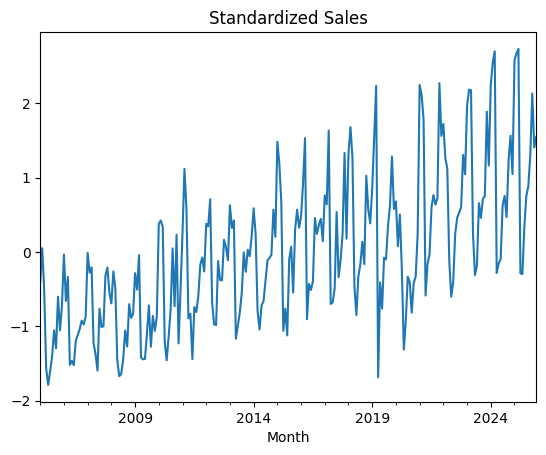

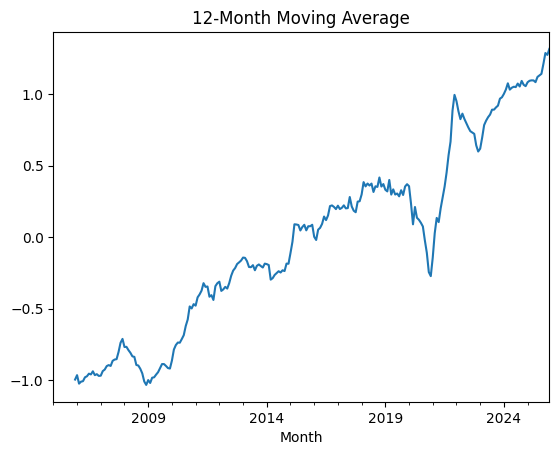

ADF Statistic: -0.41198693985399265
p-value: 0.9080780676757431
ADF Statistic after differencing: -7.7019954772899215
p-value after differencing: 1.3317261743086132e-11


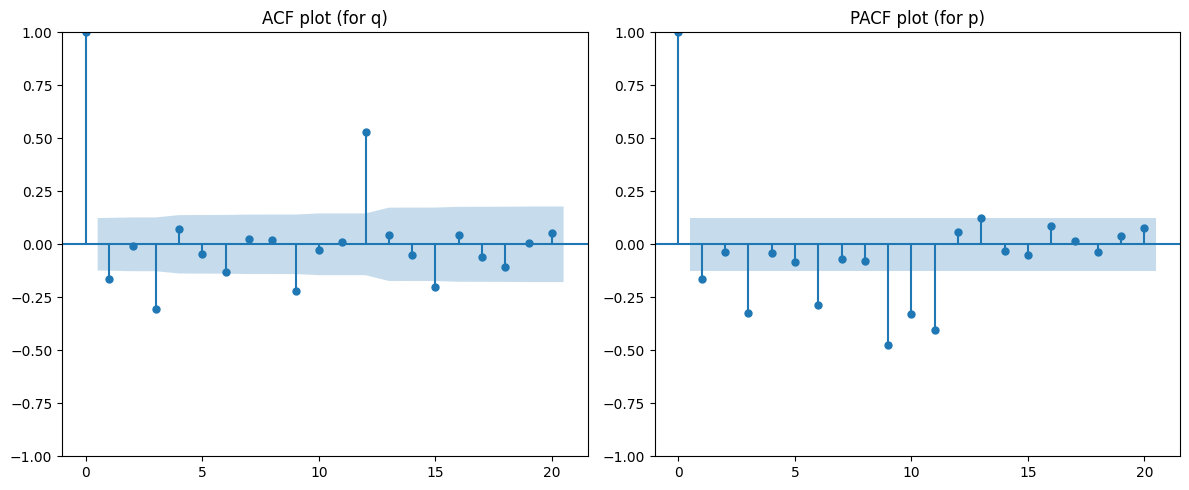

                               SARIMAX Results                                
Dep. Variable:           Sales_scaled   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -257.952
Date:                Sat, 16 Aug 2025   AIC                            521.904
Time:                        00:41:42   BIC                            532.480
Sample:                    01-31-2005   HQIC                           526.160
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5231      0.080      6.551      0.000       0.367       0.680
ma.L1         -0.9554      0.028    -33.955      0.000      -1.011      -0.900
sigma2         0.4548      0.035     13.127      0.0

/tmp/ipykernel_4435/299299692.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start='2025-09-01', end='2027-01-01', freq='M')
/home/amisha/Downloads/python/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


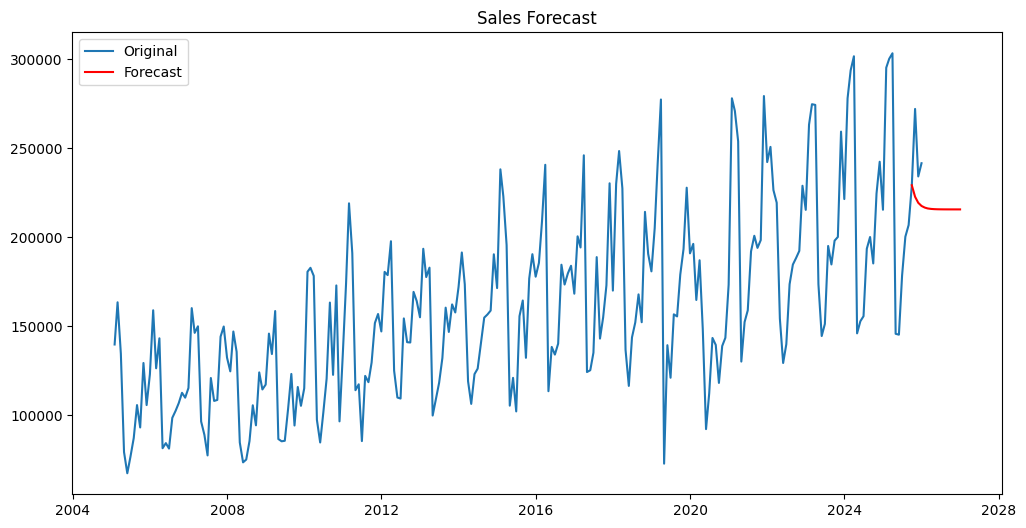

In [22]:
# Import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Sales.csv', parse_dates=['Month'], index_col='Month')
df = df.asfreq('M')  # Ensure monthly frequency

# Standardize the Sales column
scaler = StandardScaler()
df['Sales_scaled'] = scaler.fit_transform(df[['Sales']])

# Plot standardized sales
df['Sales_scaled'].plot(title='Standardized Sales')
plt.show()

# Moving average smoothing
df['MA_12'] = df['Sales_scaled'].rolling(window=12).mean()
df['MA_12'].plot(title='12-Month Moving Average')
plt.show()

# Check stationarity
result = adfuller(df['Sales_scaled'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Differencing if non-stationary
df['diff'] = df['Sales_scaled'].diff().dropna()

# Re-check stationarity
result_diff = adfuller(df['diff'].dropna())
print(f'ADF Statistic after differencing: {result_diff[0]}')
print(f'p-value after differencing: {result_diff[1]}')

# Plot ACF and PACF for differenced series to choose p and q
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(df['diff'].dropna(), lags=20, ax=plt.gca())
plt.title('ACF plot (for q)')

plt.subplot(1,2,2)
plot_pacf(df['diff'].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.title('PACF plot (for p)')
plt.tight_layout()
plt.show()

# Fit ARIMA model (adjust p,d,q based on ACF/PACF)
model = ARIMA(df['Sales_scaled'], order=(1,1,1))  # Example order
model_fit = model.fit()
print(model_fit.summary())

# Forecasting from Sept 2025 to Jan 2027
forecast_index = pd.date_range(start='2025-09-01', end='2027-01-01', freq='M')
forecast_scaled = model_fit.predict(start=len(df), end=len(df)+len(forecast_index)-1, typ='levels')

# Inverse transform to original scale
forecast = scaler.inverse_transform(forecast_scaled.values.reshape(-1,1))

# Put forecast in DataFrame
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast_Sales'])
print(forecast_df)

# Plot original and forecast
plt.figure(figsize=(12,6))
plt.plot(df['Sales'], label='Original')
plt.plot(forecast_df, label='Forecast', color='red')
plt.title('Sales Forecast')
plt.legend()
plt.show()


/tmp/ipykernel_4435/2255035290.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')


ADF Statistic: -0.41198693985399265
p-value: 0.9080780676757431
Series is non-stationary, differencing required


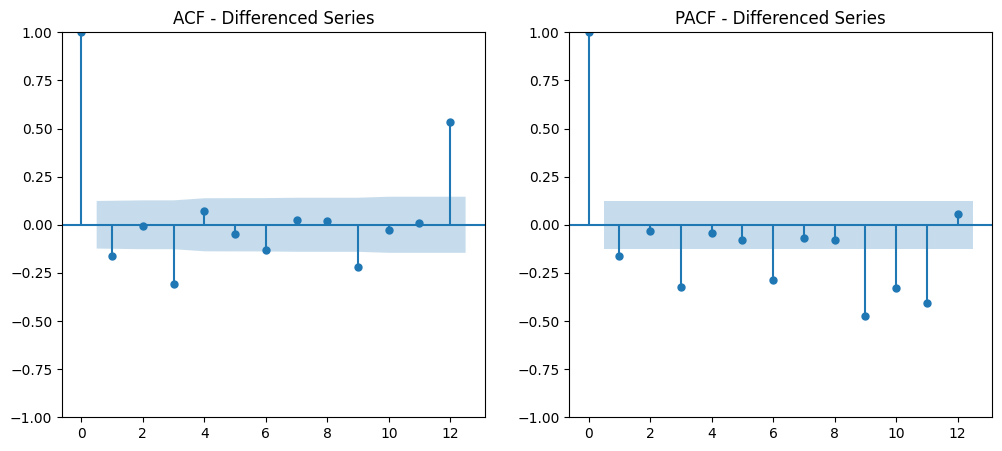

                               SARIMAX Results                                
Dep. Variable:           Sales_scaled   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -257.952
Date:                Sat, 16 Aug 2025   AIC                            521.904
Time:                        00:41:43   BIC                            532.480
Sample:                    01-31-2005   HQIC                           526.160
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5231      0.080      6.551      0.000       0.367       0.680
ma.L1         -0.9554      0.028    -33.955      0.000      -1.011      -0.900
sigma2         0.4548      0.035     13.127      0.0

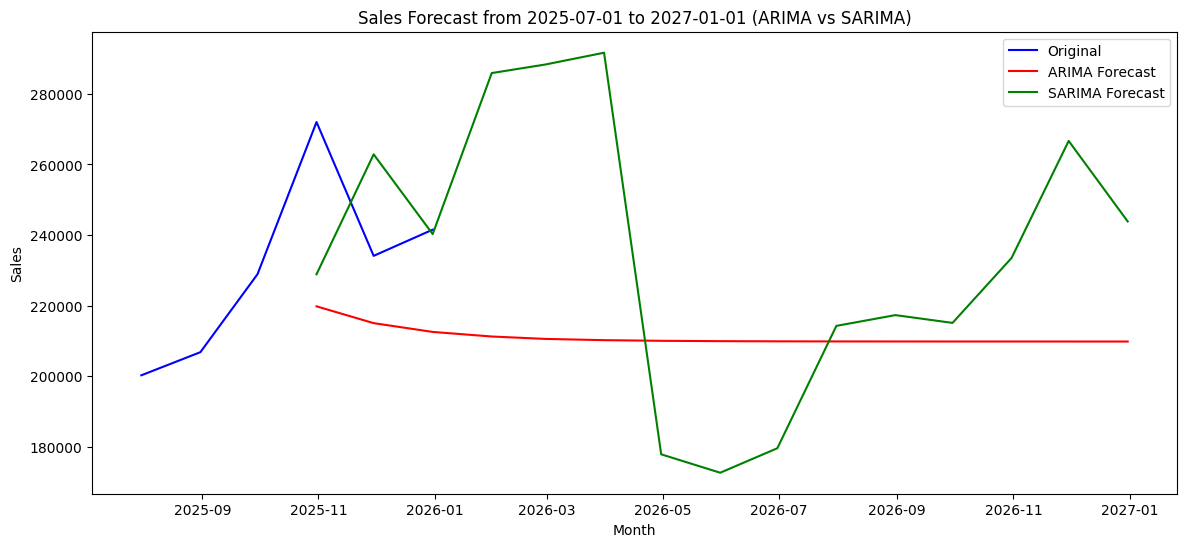

In [23]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


df = pd.read_csv('Sales.csv', parse_dates=['Month'], index_col='Month')
df = df.asfreq('M')  

scaler = StandardScaler()
df['Sales_scaled'] = scaler.fit_transform(df[['Sales']])


# Augmented Dickey-Fuller Test
adf_test = adfuller(df['Sales_scaled'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
if adf_test[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is non-stationary, differencing required")

# ---------------- Differencing if Non-Stationary ----------------
df['Sales_diff'] = df['Sales_scaled'].diff().dropna()

# Check ACF and PACF to determine p and q
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(df['Sales_diff'].dropna(), ax=plt.gca(), lags=12)
plt.title('ACF - Differenced Series')

plt.subplot(122)
plot_pacf(df['Sales_diff'].dropna(), ax=plt.gca(), lags=12)
plt.title('PACF - Differenced Series')
plt.show()

# ---------------- ARIMA Implementation ----------------
# Example orders based on plots (you may adjust p,q)
p = 1
d = 1
q = 1

arima_model = ARIMA(df['Sales_scaled'], order=(p,d,q))
arima_fit = arima_model.fit()
print(arima_fit.summary())

# ---------------- SARIMA Implementation ----------------
# Example seasonal order (P,D,Q,s) for monthly seasonality
P = 1
D = 1
Q = 1
s = 12

sarima_model = SARIMAX(df['Sales_scaled'], order=(p,d,q), seasonal_order=(P,D,Q,s))
sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

# ---------------- Forecast starting from July 2025 ----------------
start_forecast = '2025-07-01'
forecast_end = '2027-01-01'

# Slice original sales from July 2025
sales_zoom = df.loc[start_forecast:forecast_end, 'Sales']

# Slice forecasts from July 2025
forecast_arima_zoom = forecast_arima_df.loc[start_forecast:forecast_end]
forecast_sarima_zoom = forecast_sarima_df.loc[start_forecast:forecast_end]

# ---------------- Plot ----------------
plt.figure(figsize=(14,6))
plt.plot(sales_zoom, label='Original', color='blue')
plt.plot(forecast_arima_zoom, label='ARIMA Forecast', color='red')
plt.plot(forecast_sarima_zoom, label='SARIMA Forecast', color='green')
plt.title(f'Sales Forecast from {start_forecast} to {forecast_end} (ARIMA vs SARIMA)')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()

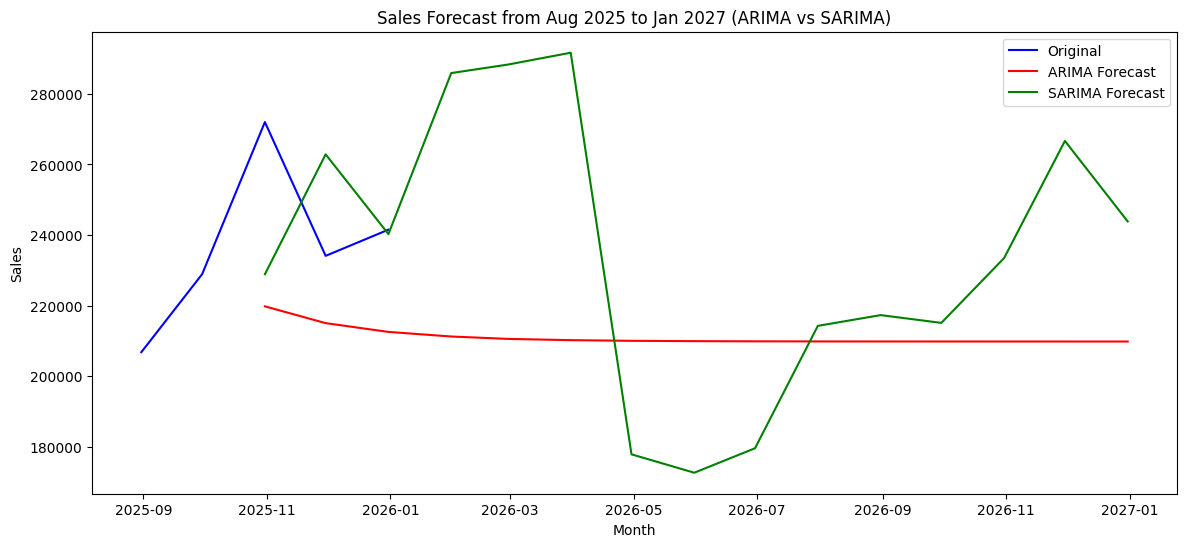

In [24]:
# ---------------- Zoomed Forecast Plot: Aug 2025 to Jan 2027 ----------------
plt.figure(figsize=(14,6))

start_zoom = '2025-08-01'
end_zoom = '2027-01-01'

# Plot original sales (if available in this range)
plt.plot(df.loc[start_zoom:end_zoom, 'Sales'], label='Original', color='blue')

# Plot ARIMA forecast
plt.plot(forecast_arima_df.loc[start_zoom:end_zoom], label='ARIMA Forecast', color='red')

# Plot SARIMA forecast
plt.plot(forecast_sarima_df.loc[start_zoom:end_zoom], label='SARIMA Forecast', color='green')

plt.title('Sales Forecast from Aug 2025 to Jan 2027 (ARIMA vs SARIMA)')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()
